# <font style="color:blue">How to Create Custom Dataset</font>

We have already seen how to load our images using the `torchvision.datasets.ImageFolder` API. 

We also know it has the following limitations:

- Root directory should have only classes directories with images in its directories. 


- It is only useful for the classification problem.


- Just using this API does not solve training and validation split.



So, we need a custom dataset class that can solve these limitations.

---

Here, we will use the same [10 Monkey Species](https://www.kaggle.com/slothkong/10-monkey-species) dataset from Kaggle to illustrate how it works. You can download the data from [here](https://www.kaggle.com/slothkong/10-monkey-species/download). You need to extract data. We have already uploaded the extracted data in the lab.


**Extracted Folder structure:**

```
data_root
├── training
│   └── training
│       ├── n0
│       ├── n1
│       ├── n2
│       ├── n3
│       ├── n4
│       ├── n5
│       ├── n6
│       ├── n7
│       ├── n8
│       └── n9
└── validation
    └── validation
        ├── n0
        ├── n1
        ├── n2
        ├── n3
        ├── n4
        ├── n5
        ├── n6
        ├── n7
        ├── n8
        └── n9

```

`data_root/training/training` has `n0-n9` folders; each folder has images of the corresponding class. Similarly, `data_root/validation/validation` has `n0-n9` folders.




**Label mapping:** Root directory also has a folder-to-Species name mapping `monkey_labels.txt` file.

```
data_root/
├── monkey_labels.txt
├── training
└── validation
```



| Label | Monkey Species |
| --- | --- |
| n0 | alouatta_palliata |
| n1 | erythrocebus_patas |
| n2 | cacajao_calvus |
| n3 | macaca_fuscata |  
| n4 | cebuella_pygmea |
| n5 | cebus_capucinus |
| n6 | mico_argentatus |
| n7 | saimiri_sciureus | 
| n8 | aotus_nigriceps |
| n9 | trachypithecus_johnii |




In [10]:
%matplotlib inline

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F

import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd

from PIL import Image

## <font style="color:green">Custom Dataset Class</font>


`torch.utils.data.Dataset` is an abstract class representing a dataset. We can write custom dataset that will inherit the `Dataset` class and override the following methods:

1. **\_\_len\_\_**: This should return the length of the dataset.


2. **\_\_getitem\_\_**: It should support indexing such that $dataset[i]$ should return $i^{th}$ sample.


Find details [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset).


In [12]:
class MonkeySpecies10Dataset(Dataset):
    """
    This custom dataset class takes root directory and train flag, 
    and returns dataset training dataset if train flag is true 
    else it returns validation dataset.
    """
    
    def __init__(self, data_root, train=True, image_shape=None, transform=None):
        
        """
        init method of the class.
        
         Parameters:
         
         data_root (string): path of root directory.
         
         train (boolean): True for training dataset and False for test dataset.
         
         image_shape (int or tuple or list): [optional] int or tuple or list. Defaut is None. 
                                             If it is not None image will resize to the given shape.
                                 
         transform (method): method that will take PIL image and transform it.
         
        """
        
        # get label to species mapping
        label_csv_path = os.path.join(data_root, 'monkey_labels.txt')
        
        self.label_df = pd.read_csv(label_csv_path, delimiter=' *, *', engine='python')
        
        
        # set image_resize attribute
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)
            
            elif isinstance(image_shape, tuple) or isinstance(image_shape, list):
                assert len(image_shape) == 1 or len(image_shape) == 2, 'Invalid image_shape tuple size'
                if len(image_shape) == 1:
                    self.image_shape = (image_shape[0], image_shape[0])
                else:
                    self.image_shape = image_shape
            else:
                raise NotImplementedError 
                
        else:
            self.image_shape = image_shape
            
        # set transform attribute
        self.transform = transform
                
        num_classes = 10
        
        # initialize the data dictionary
        self.data_dict = {
            'image_path': [],
            'label': []
        }
        
        # training data path, this will be used as data root if train = True
        if train:
            img_dir = os.path.join(data_root, 'training', 'training')
            
        # validation data path, this will be used as data root if train = False
        else:
            img_dir = os.path.join(data_root, 'validation', 'validation')
            
        for i in range(num_classes):
            class_path = os.path.join(img_dir, 'n{}'.format(i))
            for img in os.listdir(class_path):
                if img.endswith(".jpg") or img.endswith(".png"):
                    img_path = os.path.join(class_path, img)
                    self.data_dict['image_path'].append(img_path)
                    self.data_dict['label'].append(i)
                    
    def __len__(self):
        """
        return length of the dataset
        """
        return len(self.data_dict['label'])
    
    
    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        
        image = Image.open(self.data_dict['image_path'][idx]).convert("RGB")
        
        if self.image_shape is not None:
            image = F.resize(image, self.image_shape)
            
        if self.transform is not None:
            image = self.transform(image)
            
        target = self.data_dict['label'][idx]
        
        return image, target            
                
        
    def common_name(self, label):
        """
        class label to common name mapping
        """
        return self.label_df['Common Name'][label]
    
    def latin_name(self, label):
        """
        class label to latin name mapping
        """
        return self.label_df['Latin Name'][label]
        
        
        

In [18]:
# data root directory
data_root = '/content/drive/MyDrive/AI_OpenCV_PyTorch/Week7 - Project2: Kaggle Competition - Classification /dataset'

train_dataset =  MonkeySpecies10Dataset(data_root, train=True, image_shape=256)

print('Length of the dataset: {}'.format(len(train_dataset)))

img, trgt = train_dataset[300]

print('Label: {}, common name: {}, latin name: {}'.format(trgt, train_dataset.common_name(trgt), 
                                                          train_dataset.latin_name(trgt)))
plt.imshow(img)
plt.show()


FileNotFoundError: ignored

## <font style="color:green">Data Loader with Custom Dataset</font>

Let's use dataset with dataloader.

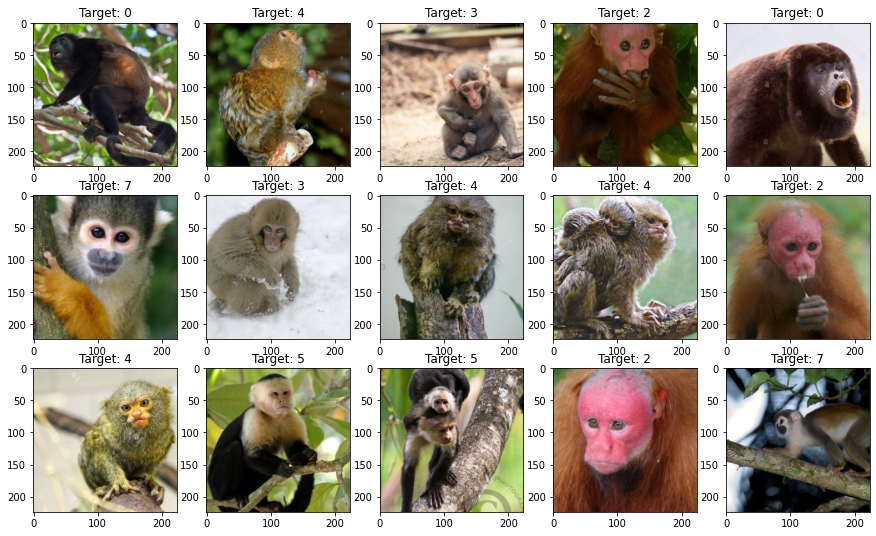

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])

test_dataset =  MonkeySpecies10Dataset(data_root, train=False, image_shape=None, transform=preprocess)

# dataloader with dataset
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=15,
        shuffle=True,
        num_workers=2
    )


# Plot few images
plt.rcParams["figure.figsize"] = (15, 9)
plt.figure
for images, labels in test_loader:
    for i in range(len(labels)):
        plt.subplot(3, 5, i+1)
        img = F.to_pil_image(images[i])
        plt.imshow(img)
        plt.gca().set_title('Target: {0}'.format(labels[i]))
    plt.show()
    break